In [51]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

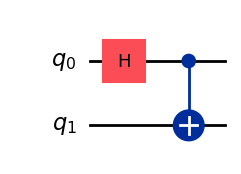

In [6]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")

In [7]:
# Create obervables
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"] # XX is X tensor X
observables = [SparsePauliOp(label) for label in observables_labels]

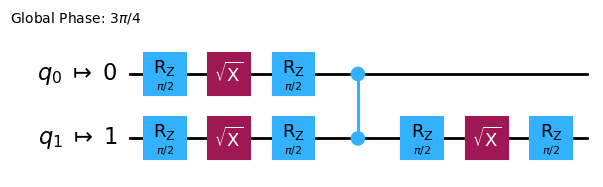

In [ ]:
# Run on real device
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
# Draws what the hardware will do which is equivilent to my qc circuit
isa_circuit.draw("mpl", idle_wires=False)

# Run on Quantum Computer

In [ ]:
# Construct the Estimator instance - Calcualted mean of 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d4ncjp9n1t7c73dha780


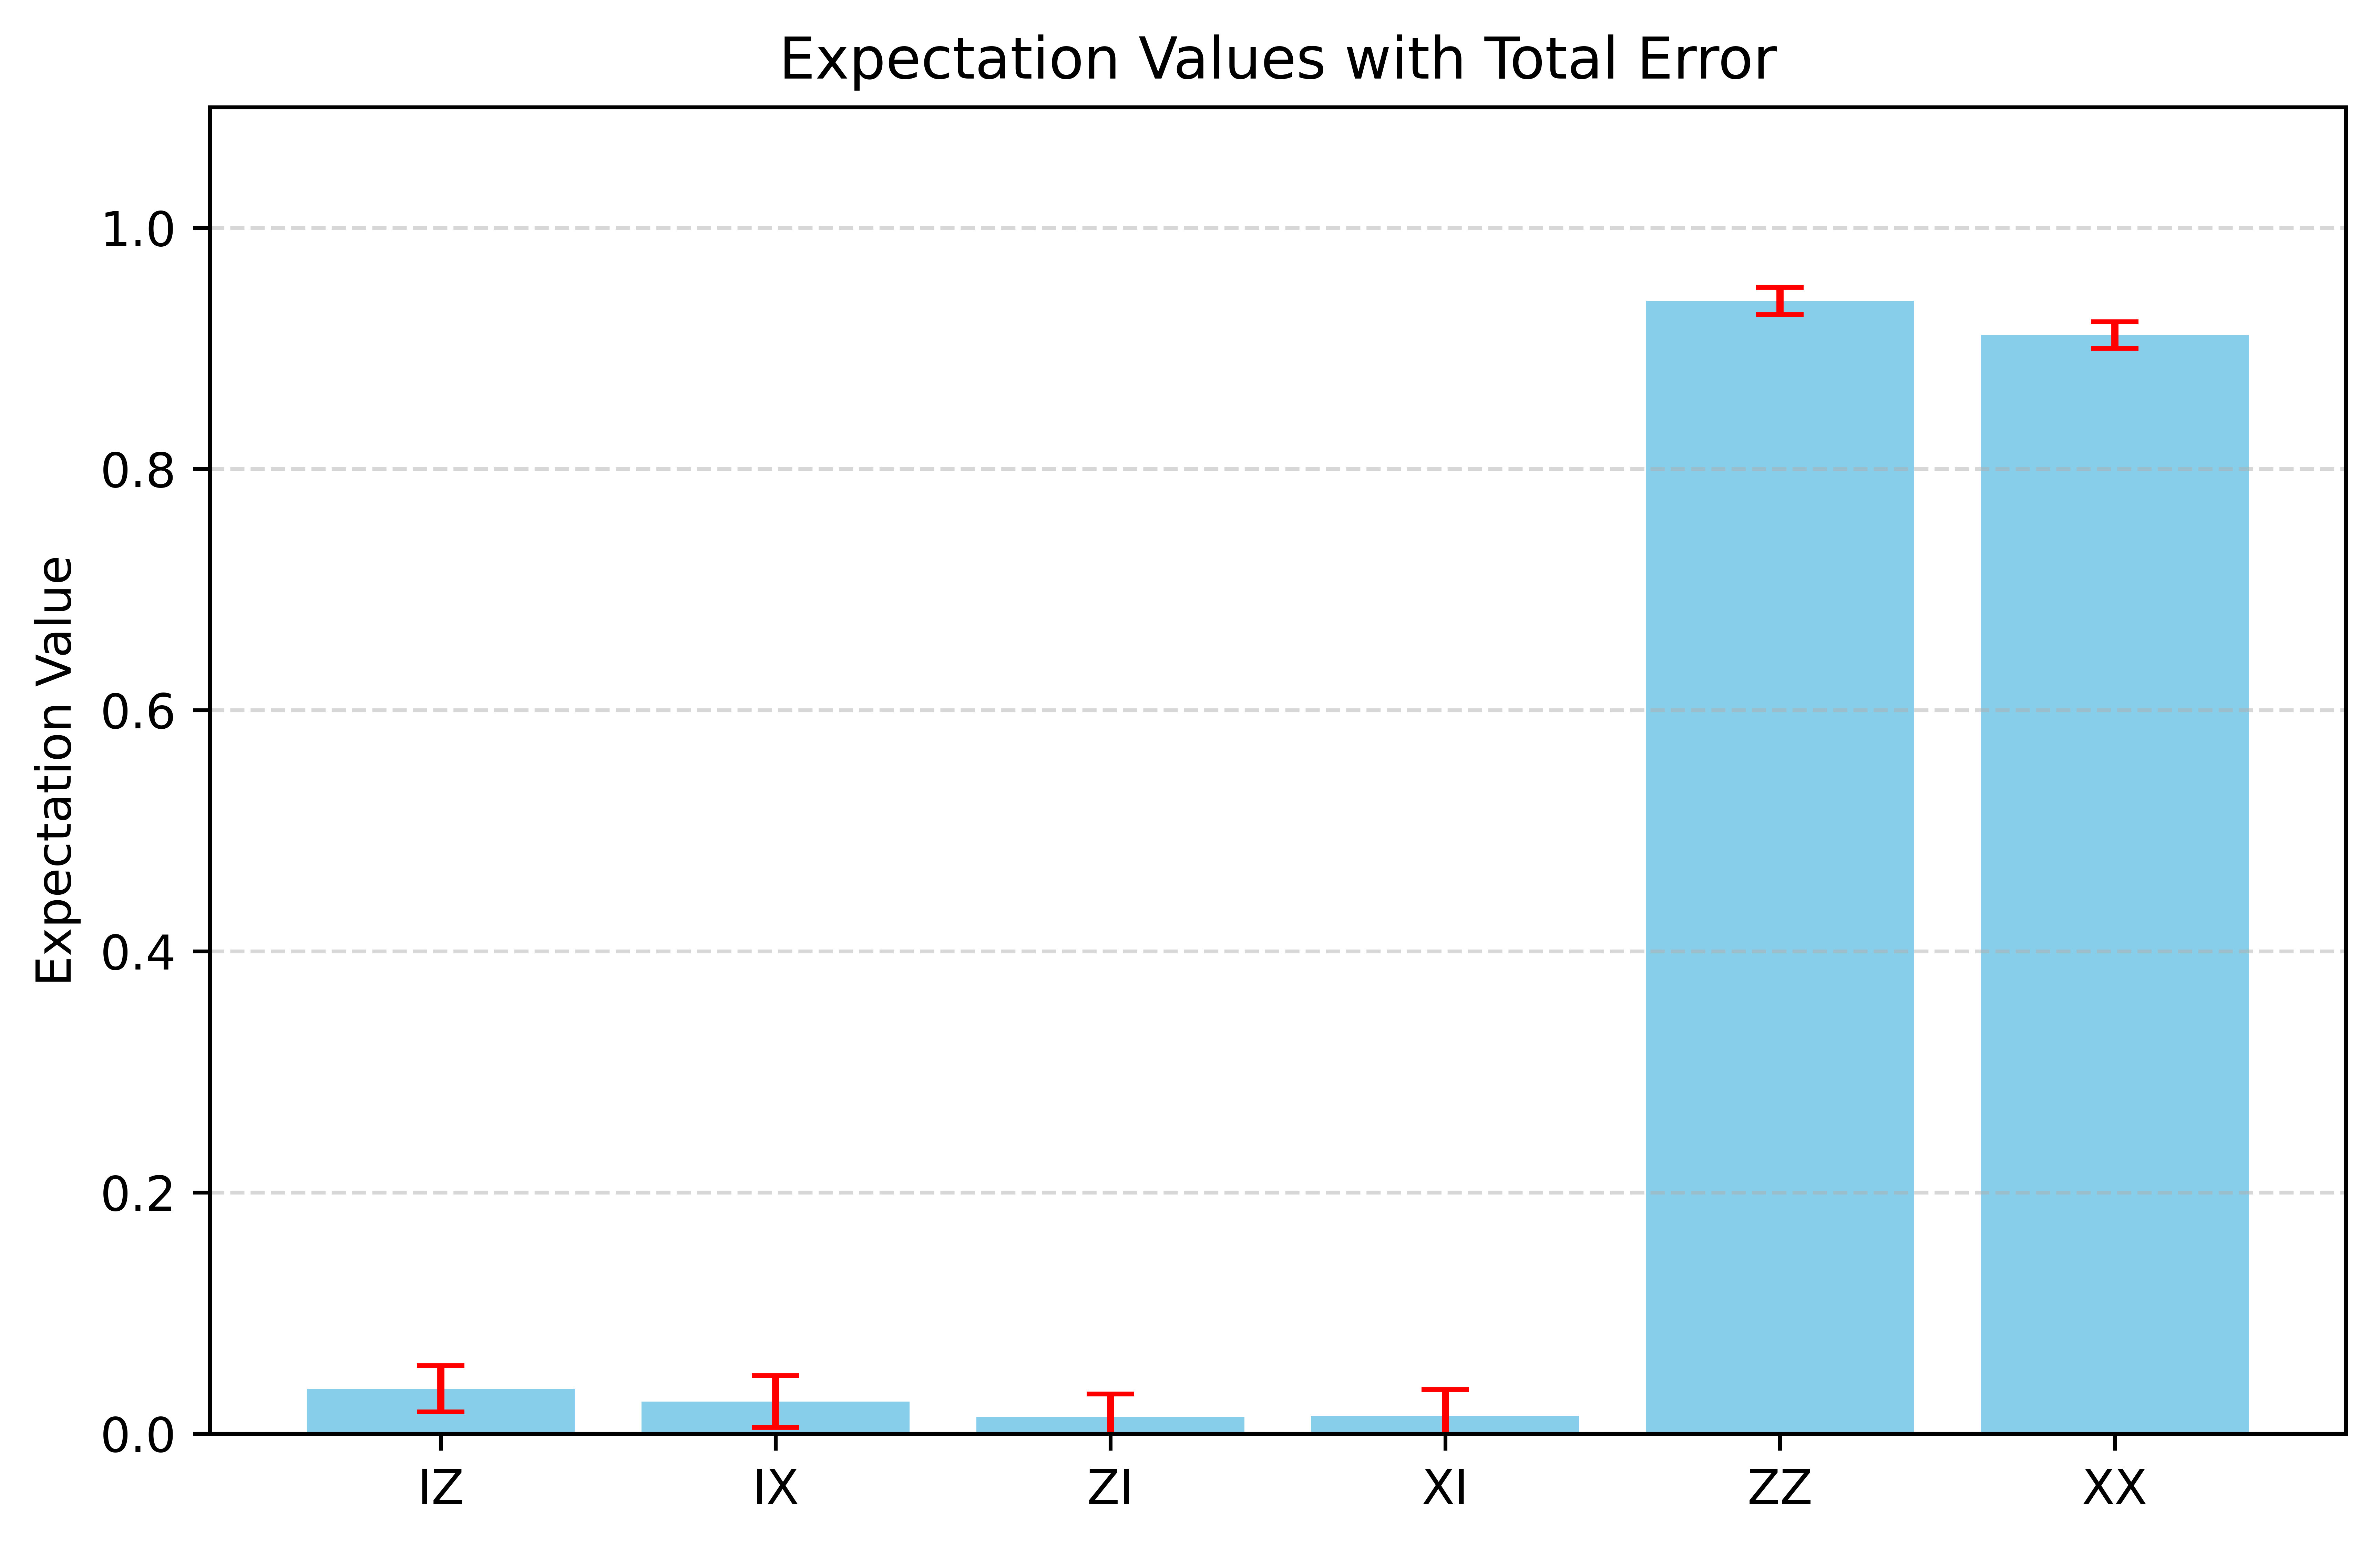

In [59]:
# Retrieve the job result
job_id = 'd4ncjp9n1t7c73dha780'
output = service.job(job_id).result()

# Access the first PubResult
pub_result = output[0]           
data = pub_result.data

# Extract the numerical results
expectation_values = data.evs
stds = data.stds
ensemble_error = data.ensemble_standard_error

# Create a pandas DataFrame
df = pd.DataFrame({
    "Observable": observables_labels,
    "Expectation": expectation_values,
    "Std Dev": stds,
    "Mitigation Error": ensemble_error,
    "~Total Error": np.sqrt(stds*stds + ensemble_error*ensemble_error)
})

# X positions
x = np.arange(len(df))

# Create the figure
plt.figure(figsize=(8,5), dpi=1000)

# Plot bars with error bars
plt.bar(
    x, 
    df["Expectation"], 
    yerr=df["~Total Error"], 
    capsize=5,           # error bar cap length
    color='skyblue',     # bar color
    ecolor='red',        # error bar color
)

# X-axis labels
plt.xticks(x, df["Observable"])

# Axis labels and title
plt.ylabel("Expectation Value")
plt.title("Expectation Values with Total Error")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Run on Simulator

In [44]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2  # 5 qubits
backend_sim = FakeManilaV2()
estimator_sim = Estimator(mode=backend_sim)

# Set the number of shots
estimator_sim.options.default_shots = 10000

pm_sim = generate_preset_pass_manager(backend=backend_sim, optimization_level=1)
isa_circuit_sim = pm_sim.run(qc)
mapped_observables_sim = [
    observable.apply_layout(isa_circuit_sim.layout) for observable in observables
]

job = estimator.run([(isa_circuit_sim, mapped_observables_sim)])
output_sim = job.result()

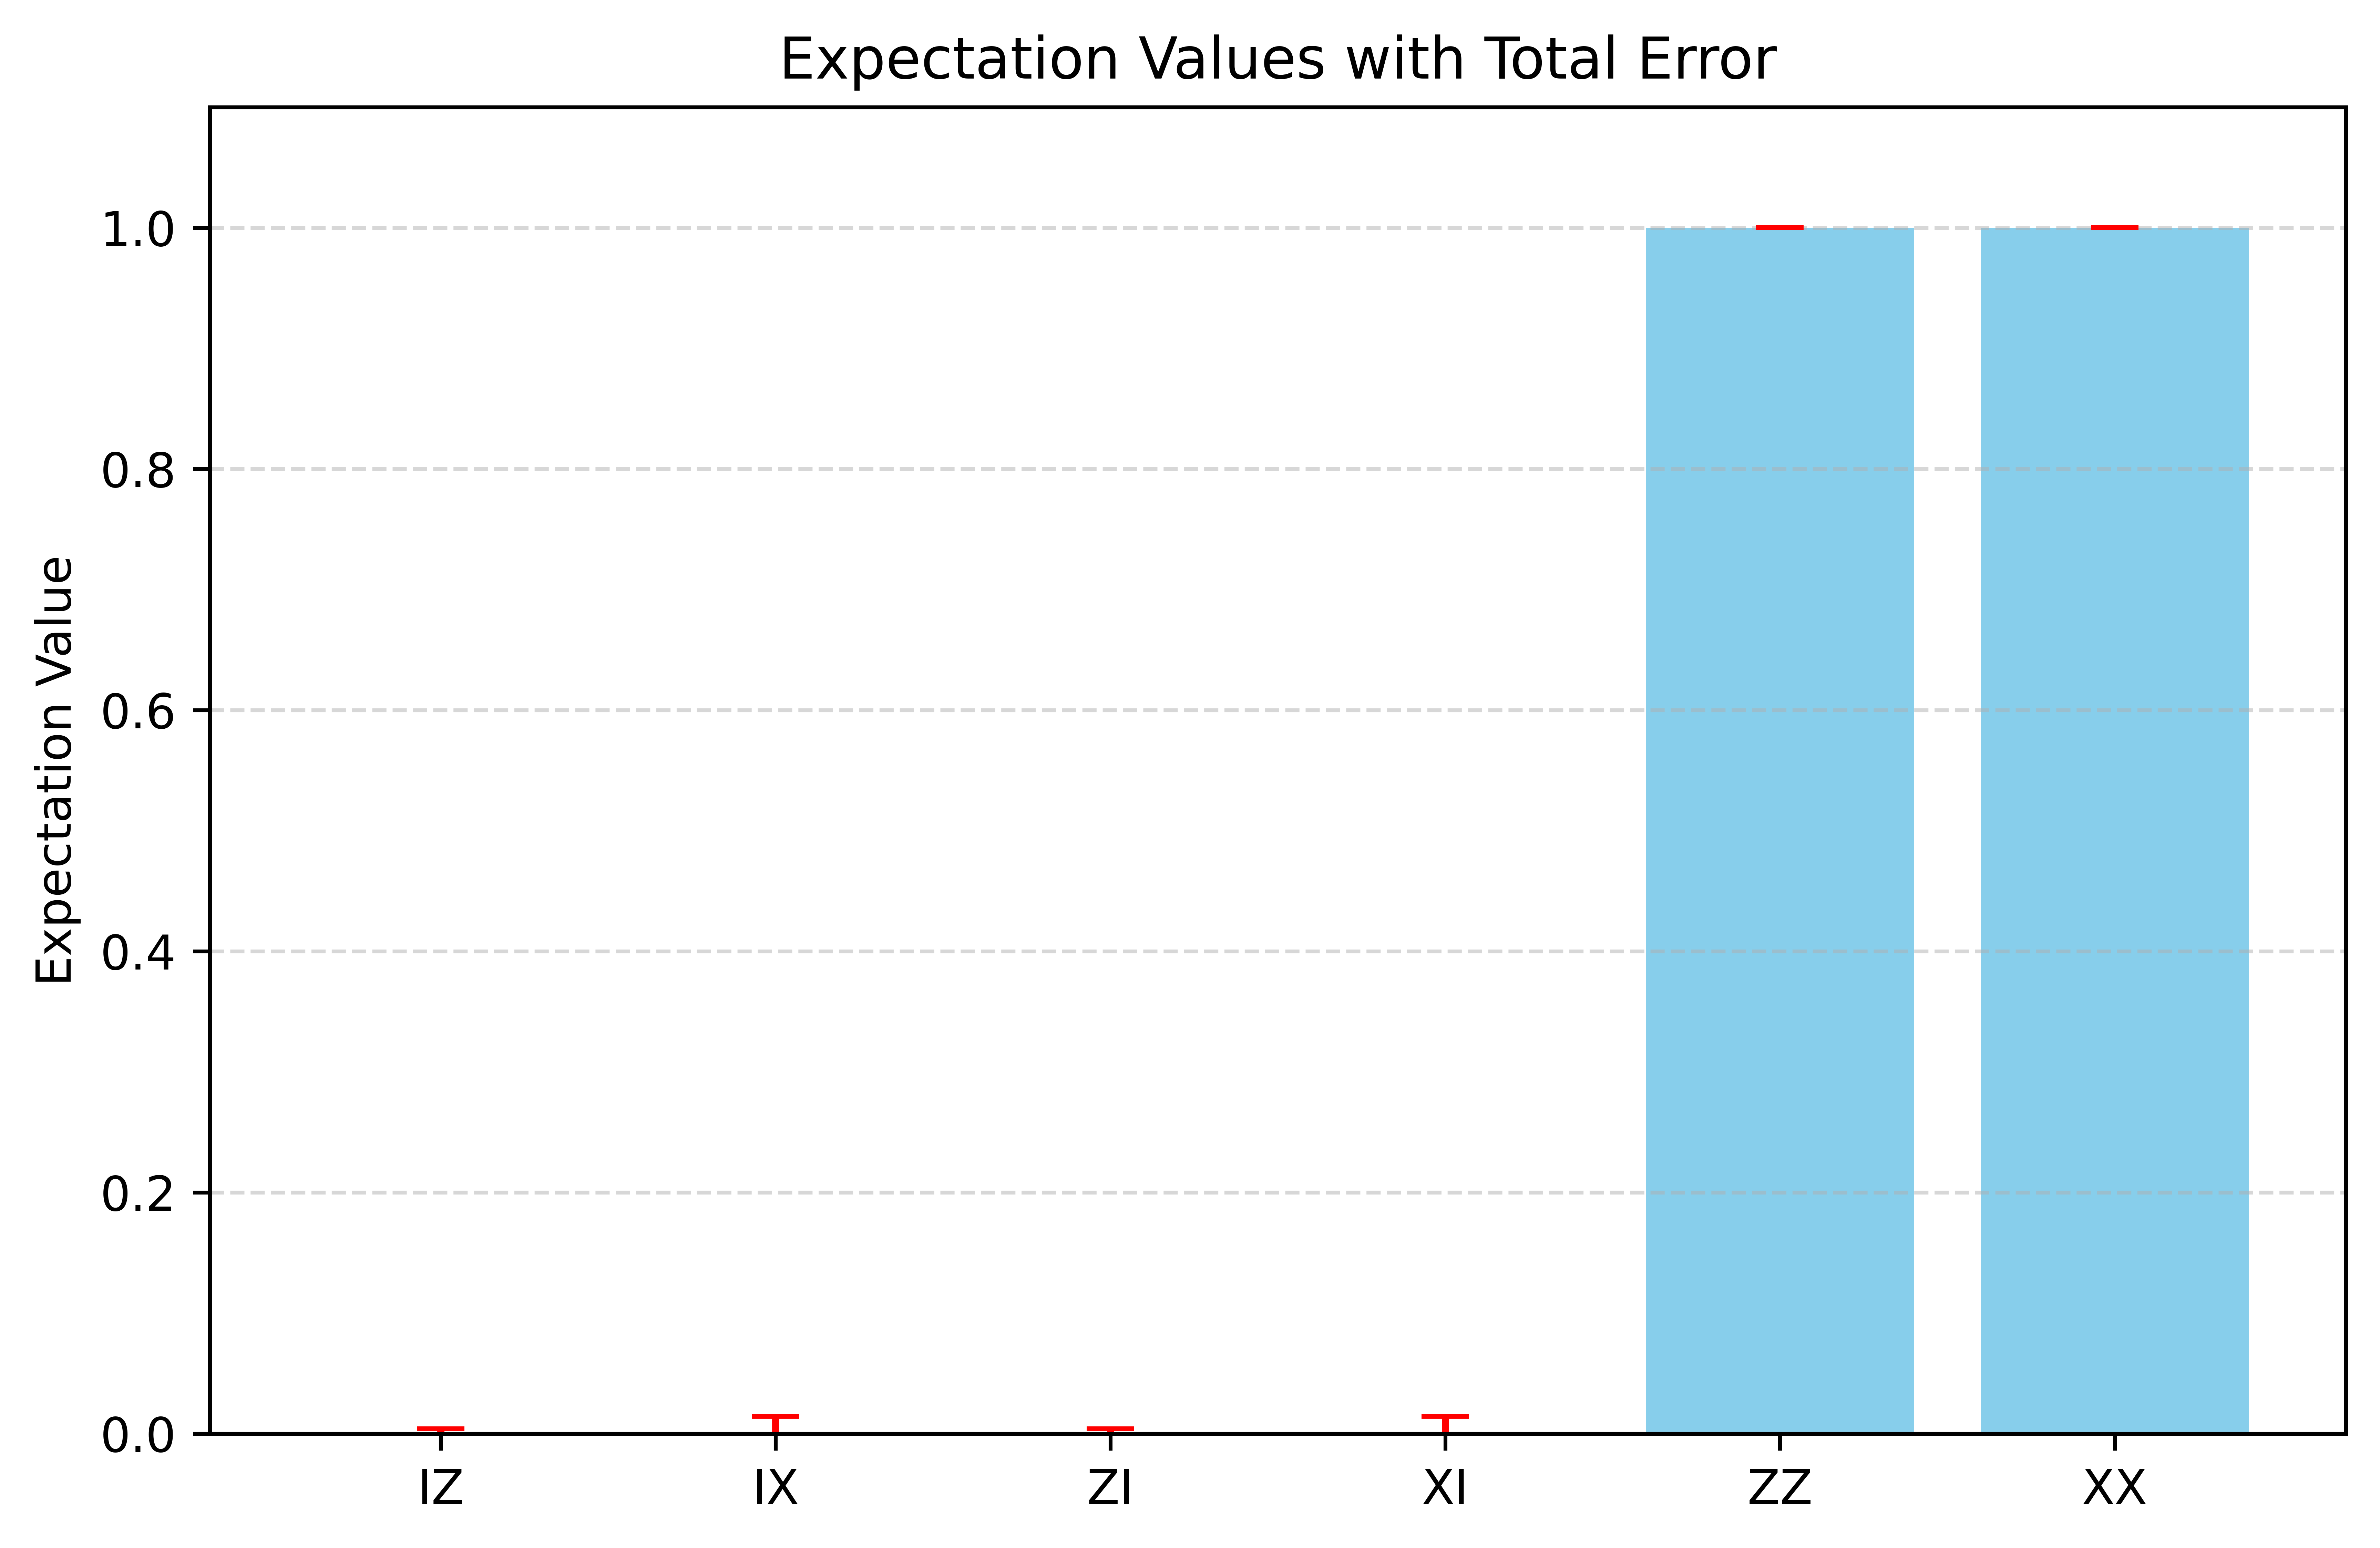

In [60]:
# Access the first PubResult
pub_result = output_sim[0]
data = pub_result.data

# Extract expectation values and standard deviations
expectation_values = data.evs
stds = data.stds

# Create pandas DataFrame
df = pd.DataFrame({
    "Observable": observables_labels,
    "Expectation": expectation_values,
    "Std Dev": stds
})

# X positions
x = np.arange(len(df))

# Create the figure
plt.figure(figsize=(8,5), dpi=1000)

# Plot bars with error bars
plt.bar(
    x, 
    df["Expectation"], 
    yerr=df["Std Dev"], 
    capsize=5,           # error bar cap length
    color='skyblue',     # bar color
    ecolor='red',        # error bar color
)

# X-axis labels
plt.xticks(x, df["Observable"])

# Axis labels and title
plt.ylabel("Expectation Value")
plt.title("Expectation Values with Total Error")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)